## Add full state feedback

In [1]:
import matplotlib.pyplot as plt   # MATLAB plotting functions
import control
import control.matlab
import numpy as np

In [2]:
# Parameters defining the system from before

# System matrices
A = np.matrix( [[0, 1.],
                [0,0]] )
B =  np.matrix( [[0],
                [350.]] )

C =  np.matrix( [[1., 0]] )

syst = control.ss(A, B, C, 0)

## convert continuous time system (sys) to discrete time system (sysd) with timestep 0.1
Tstep = 0.1
sysd = control.matlab.c2d(syst,Tstep)

print(sysd)

A = [[1.  0.1]
 [0.  1. ]]

B = [[ 1.75]
 [35.  ]]

C = [[1. 0.]]

D = [[0.]]

dt = 0.1



## Compute feedback matrix using pole placement.
Reasonable poles were chosen that wouldn't demand extreme controller movements.

In [3]:
poles = [-2.2, -2.]

Kfeedback = control.place(syst.A, syst.B, poles)
# print(S)
# print(E)

print("Feedback matrix is:")
print(Kfeedback)

## print DC gain. Can also be computed as -(C * (syst.A - syst.B@Kfeedback)^-1 * B)
## dcgain = control.matlab.dcgain(sysFeedback)
dcgain =  (-C*(A - B@Kfeedback).I *B )[0,0]


Feedback matrix is:
[[0.01257143 0.012     ]]


## Simulate closed loop system
Once the system state is fed back through the feedback gain, the new A matrix becomes

Afeedback = (A - B \* K)
Where K is the feedback found above. The eigenvalues of this new system will be the poles chosen above.

The gain becomes non-unity however. The settling time looks to be about right for the poles chosen above, i.e. ~ e^(-2*t).

In the plot below are shown effects of pole placement for faster and slower poles.

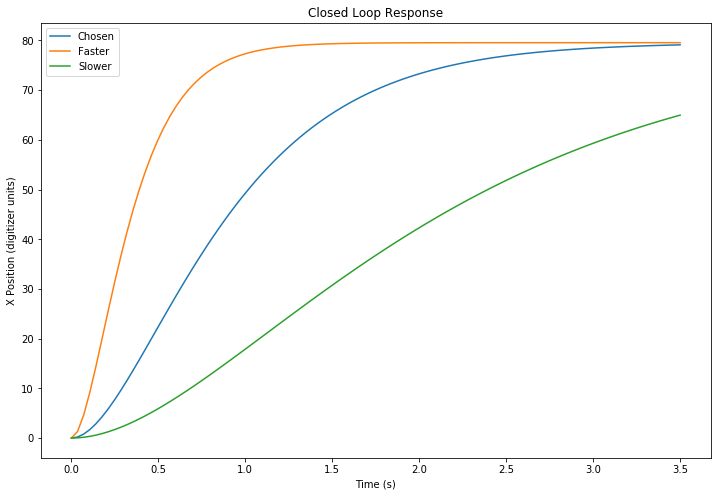

79.54545454545469


In [4]:
plt.figure(figsize=(12,8))
plt.xlabel('Time (s)')
plt.ylabel('X Position (digitizer units)')
plt.title('Closed Loop Response')

feedbackA = syst.A - syst.B@Kfeedback  ## feedback system A matrix
sysFeedback = control.ss(feedbackA, syst.B, syst.C, 0)
T ,yout = control.step_response( sysFeedback)
plt.plot(T,yout, label='Chosen')

dcgain = control.matlab.dcgain(sysFeedback)

###### Show effects of slower and faster poles
poleArray = [ [-5,-6],[-0.8, -1.]]      
labelArray = ['Faster', 'Slower']
for poles, label in zip(poleArray, labelArray):
    Ktemp= control.place(syst.A, syst.B, poles)
    sysTemp = control.ss( syst.A - syst.B@Ktemp, B, C,0) 
    T ,yout = control.step_response( sysTemp, T=np.linspace(0,3.5,100))
    plt.plot(T,yout * dcgain / control.matlab.dcgain(sysTemp), label = label) ## normalize for gain

plt.legend(loc="upper left")
plt.show()
print(control.dcgain(sysFeedback))

## Simulate the natural response
This can be done with the control.matlab.lsim function but do it manually just to see.

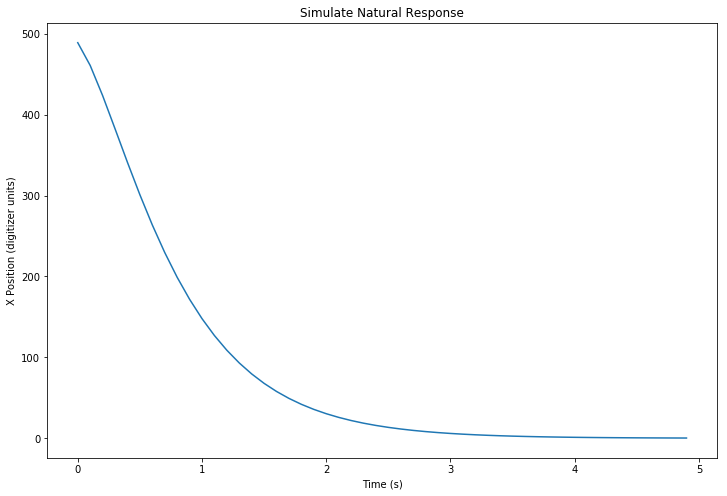

In [5]:
x= np.matrix([[500], [0]])  ## initial value. 512 is max value of touchscreen.

yout = []
controls = []

for i in range(50):
    u =  -Kfeedback @ x    ## can add offset here
    x = sysd.A* x + sysd.B @ u  ## update system

    yout.append(x[0,0])         ## append position
    controls.append(u[0,0])     ## append control, u

t = np.arange(50)*Tstep

plt.figure(figsize=(12,8))

plt.xlabel('Time (s)')
plt.ylabel('X Position (digitizer units)')
plt.title('Simulate Natural Response')

plt.plot(t,yout)
plt.show()

Make sure that control responses necessary for above response are reasonable.

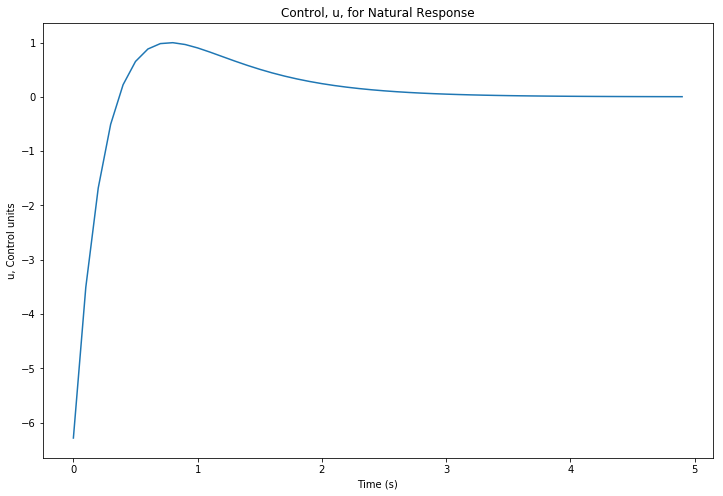

In [6]:
plt.figure(figsize=(12,8))

plt.xlabel('Time (s)')
plt.ylabel('u, Control units')
plt.title('Control, u, for Natural Response')
plt.plot(t,controls)
plt.show()

## Make an Observer
In many cases, the full state of the system is not available. In this simple system, only two states exist, the position and the velcity, so the velocity can be obtained by computing the delta X divided by Tstep. The proper way is to use an observer.

Full disclosure: The actual order of events was that I tried to implement a Kalman observer/filter. It was trickier than I thought. So I fell back to a "Luenberger" observer. I still plan on going back to a real Kalman observer to correct for the glitches in the touchscreen input.

It turns out that the observer is in itself a state space system! Who knew? The Kobs gain is selected so that the observed or estimated state will converge to the actual state of the system given the system is observable. The estimated state will be:

xhat\[k\] = Obs.A \* xhat\[k-1\] + Obs.B \* Obs.u

Where Obs.u is the matrix of measured value, and control u given to the "real" system. Obs.A and Obs.B are the system matrices for the observer system.

In [7]:
### find feedback for observer with slightly faster poles than for control feedback.
poles = [-7, -8]
Kobs = control.place(syst.A.T, syst.C.T, poles).T
sysObs = control.ss(syst.A - Kobs @ syst.C, np.concatenate( (syst.B, Kobs), axis=1), np.eye(2), 0 )

### now make discrete time so we can compute system state recursively
sysObsd = control.matlab.c2d(sysObs,Tstep)

print("Feedback matrix for Luenberger observer:")
print(Kobs)
print("\nSystem matrices for observer:")
print(sysObsd)

Feedback matrix for Luenberger observer:
[[15.]
 [56.]]

System matrices for observer:
A = [[ 0.11853459  0.04725634]
 [-2.64635502  0.82737968]]

B = [[ 1.07887699  0.88146541]
 [32.72287374  2.64635502]]

C = [[1. 0.]
 [0. 1.]]

D = [[0. 0.]
 [0. 0.]]

dt = 0.1



## Simulate feedback with observer

Now use the observer estimate to build a closed loop system. The observer estimate is  multiplied by the feedback gain and fed back into the system.

Here both the observer and "real" systems are simulated using the appropriate system matrices. When translating to Arduino, you don't need to compute the "real" system because that will be taken care of by a ball, touchscreen, and servos-- the position will be measured on a touchscreen and the command output will be sent to the servos to tilt the touchscreen. The physical world provides the simulation! The observer is needed to get a "full state." Which in this simple example could be done with subtraction and scaling by Tstep. But this is a step toward implementing a Kalman estimator.

In [8]:

obs_U = np.zeros((2,1))         ## Input to the observer system
xhat = np.matrix([[200],[0]])   ## set initial xhat value for observer system

### here 
x= np.matrix([[500], [0]])    ## set initial value of x. Mismatched from xhat

xdesired = np.zeros(200)
xdesired[100:150]= 200  ## need to scale by dcgain so output of system goes to desired

xArray = np.matrix([[0], [0]])
xhatArray = np.matrix([[0], [0]])
uArray = np.matrix([0]).reshape(1,1)

u = np.matrix(0)

for i in range(200):
    measuredX = x[0,0]              ## "measure" position from "real" system state

    obs_U[0,0] = u               ## construct observer u. 
    obs_U[1,0] = measuredX

    ### compute new observer estimate
    xhat = sysObsd.A @ xhat + sysObsd.B @ obs_U  ## compute observer estimate

    u =  -Kfeedback @ xhat + xdesired[i]/dcgain   ## can add command offset here

    xArray = np.concatenate((xArray, x), axis = 1)          ## save "real" states
    xhatArray = np.concatenate((xhatArray, xhat), axis = 1) ## save observed states
    uArray = np.concatenate((uArray, u), axis = 1)          ## save control inputs

    x = sysd.A @ x + sysd.B @ u   ## compute "real" system Arduino doesn't need this
                                  ## because u is sent to tilt the table and position is measured
                                  ## from the touchscreen

t = np.arange(200 + 1)* Tstep

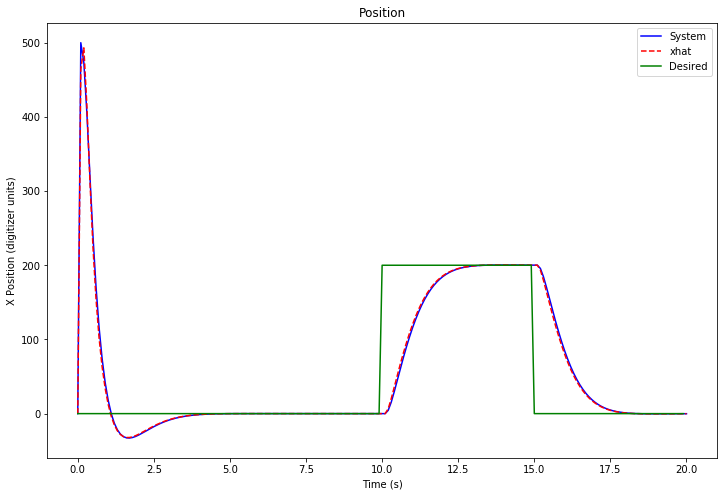

In [9]:
plt.figure(figsize=(12,8))

plt.plot(t,xArray[0,:].T, 'b',label = 'System')
plt.plot(t,xhatArray[0,:].T, 'r--', label = 'xhat')
plt.plot(t[:200], xdesired , 'g-',label='Desired')

plt.legend(loc="upper right")
plt.title('Position')
plt.xlabel('Time (s)')
plt.ylabel('X Position (digitizer units)')
plt.show()

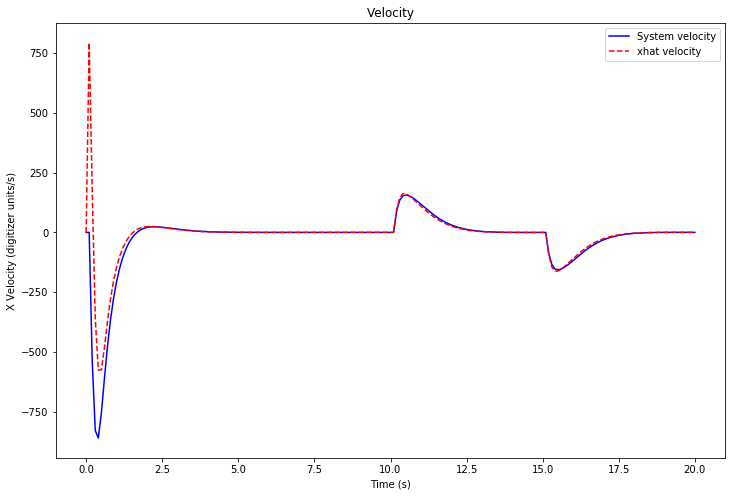

In [10]:
plt.figure(figsize=(12,8))

plt.plot(t,xArray[1,:].T, 'b-',label='System velocity')
plt.plot(t,xhatArray[1,:].T, 'r--',label='xhat velocity')
plt.title('Velocity')
plt.xlabel('Time (s)')
plt.ylabel('X Velocity (digitizer units/s)')
plt.legend(loc="upper right")
plt.show()

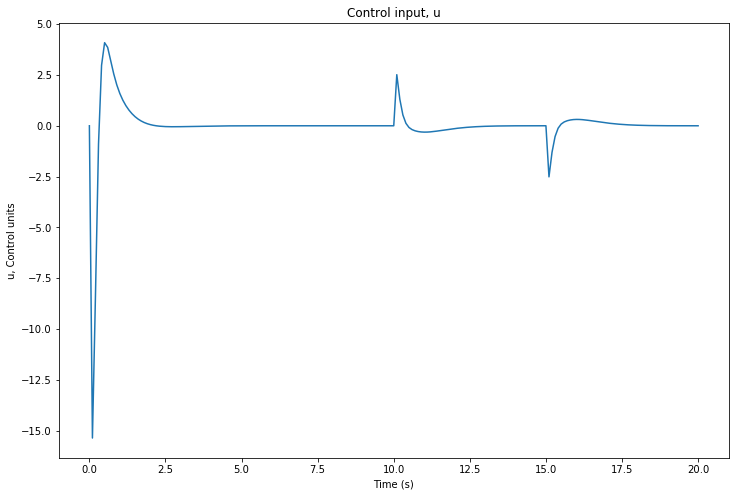

In [11]:
plt.figure(figsize=(12,8))

plt.plot(t,uArray[0:].T)
plt.title('Control input, u')
plt.xlabel('Time (s)')
plt.ylabel('u, Control units')
plt.show()

## Translate above to Arduino

So the above code was converted into something the Arduino could handle and after a bit of fiddling, it would balance the ball. But the results were far worse than what the PID controller could do, especially in regards to steady state error. The ball would stay on the table but thats about it. Deviation from ideal behavior, e.g. rolling friction and small offsets in table tilt, made for lack-luster steady state response. And I think I'm being generous calling it lack-luster.

I had naively thought that state space control automatically fixed all such problems. It was a somewhat sobering realization. But what state space taketh away, state space giveth...

Next up, robustness methods, namely, the addition of a integrator.